# Project: China Scientific Leadership

**Notebook:** FigS1_OpenAlex2023_Publication_Statistics_by_Region_Pair.ipynb

**Authors:** Renli Wu, Christopher Esposito, James Evans

**Affiliations:** School of Information Management, Wuhan University / Knowledge Lab, University of Chicago / University of California, Los Angeles

**Date:** 2024-11-29 (UTC)
**Version:** v0.3.0

**Purpose:**
This notebook generates **Figure S1** for the Supplementary Information, which presents the statistics of publications across different region pairs over time.

**Inputs:**
- `data/OpenAlex2023_Paper_Author_Lead_Pro_dataset.csv.gz`

**Outputs:**
- `pics/fig_S1.svg`
- `pics/fig_S1_extra.svg`

**Notes:**
See `README.md` for details on environment setup, dependencies, and execution order within the full analysis pipeline.


In [1]:
import numpy as np
import pandas as pd
import time

### Load the leadership dataset

In [2]:
%%time
print(time.strftime('%l:%M%p %Z on %b %d, %Y'))
data = pd.read_csv("./data/OpenAlex2023_Paper_Author_Lead_Pro_dataset.csv.gz", compression="gzip")
print(time.strftime('%l:%M%p %Z on %b %d, %Y'), data.shape)
data.head()

 7:23AM CDT on Sep 17, 2025


<timed exec>:2: DtypeWarning: Columns (9,14,15) have mixed types. Specify dtype option on import or set low_memory=False.


 7:25AM CDT on Sep 17, 2025 (42995311, 22)
CPU times: user 1min 58s, sys: 10.3 s, total: 2min 9s
Wall time: 2min 9s


,paperId,authorId,publication_year,Lead_Pro,region,China_US,China_EU+,China_UK,US_EU+,UK_EU+,...,China_BeltRoad_HighIncome,China_BeltRoad_LowIncome,US_BeltRoad_HighIncome,US_BeltRoad_LowIncome,jif_2021,jif_mid,11_technical_area,fos_6,Honorary_authors,Matched_in_WOS
0,W3135965258,A5021665664,2021,0.155624,East Asia,False,False,False,False,False,...,False,False,NaN,NaN,1-5,3.0,DIS;EG;HPC;MAT;SC,earth & life science;chemistry & materials sci...,False,True
1,W3135965258,A5032223512,2021,0.263628,East Asia,False,False,False,False,False,...,False,False,NaN,NaN,1-5,3.0,DIS;EG;HPC;MAT;SC,earth & life science;chemistry & materials sci...,False,True
2,W3135978430,A5058653785,2021,0.300942,EU+,False,False,False,False,False,...,False,False,NaN,NaN,5-10,7.5,DIS;EG;MAT,mathematics & physics & engineering;chemistry ...,False,True
3,W3135978430,A5062473161,2021,0.689903,EU+,False,False,False,False,False,...,False,False,NaN,NaN,5-10,7.5,DIS;EG;MAT,mathematics & physics & engineering;chemistry ...,False,True
4,W3135978430,A5006524513,2021,0.242909,Latin America,False,False,False,False,False,...,False,False,NaN,NaN,5-10,7.5,DIS;EG;MAT,mathematics & physics & engineering;chemistry ...,False,True


### Country-Pair Publication Statistics – Line Chart

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D

In [4]:
# ---------- Config ----------
pairs = [
    ("China", "U.S."), ("China", "U.K."),
    ("China", "EU+"), ("U.S.", "EU+"),
    ("U.S.", "U.K."), ("Russia", "EU+"),
    ("China", "BeltRoad_HighIncome"), ("China", "BeltRoad_LowIncome"),
]
belt_pairs = {"China/BeltRoad_HighIncome", "China/BeltRoad_LowIncome"}
custom_dash_pattern = (1.5, .51)

# Colors
color_dict = {
    "China/U.S.":"#1f77b4", "China/U.K.":"#ff7f0e", "China/EU+":"#1b9e77",
    "U.S./EU+":"#a7c957", "U.S./U.K.":"#a6cee3", "Russia/EU+":"#fb9a99",
    "China/BeltRoad_HighIncome": "#00b4d8",
    "China/BeltRoad_LowIncome":  "#ffb703"
}

In [6]:
def thousands_formatter(x, _):
    """Format large ticks like 12.3k."""
    if x >= 1000:
        v = np.round(x/1000, 1)
        return f"{int(v)}k" if v == int(v) else f"{v}k"
    return str(int(x))

def build_pair_time_series(df: pd.DataFrame, pairs):
    """
    Build tidy dataframe with columns [publication_year, paperId, pair].
    """
    out = []
    for c1, c2 in pairs:
        col = f"{c1.replace('.','')}_{c2.replace('.','')}"
        if col not in df.columns:
            continue
        tmp = (
            df.loc[df[col] == True, ["paperId", "publication_year"]]
              .drop_duplicates(["paperId"])
              .groupby("publication_year", observed=True)["paperId"]
              .count()
              .reset_index()
        )
        tmp["pair"] = f"{c1}/{c2}"
        out.append(tmp)
    return pd.concat(out, ignore_index=True) if out else pd.DataFrame(columns=["publication_year","paperId","pair"])

def legend_sorted_by_last_year(ax, sort_df, last_year, dash_pairs, dash_pattern):
    """
    Legend ordered by last-year publications (desc)
    """
    # totals at last_year (0 if missing)
    last_vals = (
        sort_df[sort_df["publication_year"] == last_year]
        .groupby("pair", observed=True)["paperId"].sum()
        .reindex(sorted(sort_df["pair"].unique()))
        .fillna(0)
    )
    hue_order = last_vals.sort_values(ascending=False).index.tolist()

    handles, labels = ax.get_legend_handles_labels()
    seen = {}
    for h, lab in zip(handles, labels):
        if lab in hue_order and lab not in seen:
            seen[lab] = h

    ordered_labels = [p for p in hue_order if p in seen]
    ordered_handles = [seen[p] for p in ordered_labels]

    leg = ax.legend(ordered_handles, ordered_labels, bbox_to_anchor=(1.05, 1),
                    loc='upper left', frameon=False,
                    prop={'size': 15, 'weight': 'bold'})
    for line, text in zip(leg.legendHandles, leg.get_texts()):
        pair = text.get_text()
        line.set_linewidth(10)
        text.set_fontsize(20)
        text.set_weight('bold')
        if isinstance(line, Line2D) and pair in dash_pairs:
            line.set_linestyle((0, dash_pattern))  # show dashed in legend
    return leg

def style_axes(ax, xlim, ylim):
    """Apply axes limits and typography."""
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_xlabel("Year", labelpad=15, fontsize=20, weight="bold")
    ax.set_ylabel("Publications", fontsize=20, labelpad=15, weight="bold")
    ax.set_title("OpenAlex - Dec. 2023", pad=15, fontsize=20)
    ax.tick_params(axis='y', which='both', pad=10)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))
    for lab in ax.get_yticklabels():
        lab.set_fontsize(15)
    # keep seaborn's locators; just set fonts
    xt = ax.get_xticks()
    ax.set_xticklabels([int(t) if float(t).is_integer() else f"{t:.0f}" for t in xt], weight='bold', fontsize=15)

def plot_region_pairs(df_all, df_belt, color_dict, dash_pairs, xlim, ylim, save_file_name, dash_pattern=(1.5, .51)):
    """
    Draw lines for main pairs (solid) and BeltRoad pairs (dashed).
    """
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='white')

    base = dict(x="publication_year", y="paperId", hue="pair", palette=color_dict, ax=ax, legend=True)

    # Solid lines (non-BeltRoad)
    if not df_all.empty:
        sns.lineplot(data=df_all, linewidth=6, **base)

    # Dashed lines (BeltRoad)
    if not df_belt.empty:
        sns.lineplot(data=df_belt, linewidth=7, linestyle=(0, dash_pattern), **base)

    # Apply limits AFTER plotting
    style_axes(ax, xlim=xlim, ylim=ylim)

    # Legend ordered by last-year publications
    last_year = int(min(xlim[1], (pd.concat([df_all, df_belt])["publication_year"].max()
                                  if not pd.concat([df_all, df_belt]).empty else xlim[1])))
    all_for_sort = pd.concat([df_all, df_belt], ignore_index=True)
    legend_sorted_by_last_year(ax, all_for_sort, last_year, dash_pairs, dash_pattern)
    plt.savefig(
        f"./pics/{save_file_name}.svg",
        facecolor='white', bbox_inches='tight', format="svg", dpi=300
    )
    plt.show()


In [7]:
# ---------- Build data ----------
df_line_all = build_pair_time_series(data, pairs)
df_line_all = df_line_all[df_line_all["publication_year"] <= 2023].copy()

# Split BeltRoad vs others
df_line_belt = df_line_all[df_line_all["pair"].isin(belt_pairs)].copy()
df_line_main = df_line_all[~df_line_all["pair"].isin(belt_pairs)].copy()

# Sort for stable plotting
df_line_all.sort_values(["publication_year", "paperId"], ascending=[True, False], inplace=True)
df_line_belt.sort_values(["publication_year", "paperId"], ascending=[True, False], inplace=True)
df_line_main.sort_values(["publication_year", "paperId"], ascending=[True, False], inplace=True)

/home/renly/.local/lib/python3.11/site-packages/seaborn/_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/renly/.local/lib/python3.11/site-packages/seaborn/_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/renly/.local/lib/python3.11/site-packages/seaborn/_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/renly/.local/lib/python3.11/site-packages/seaborn/_c

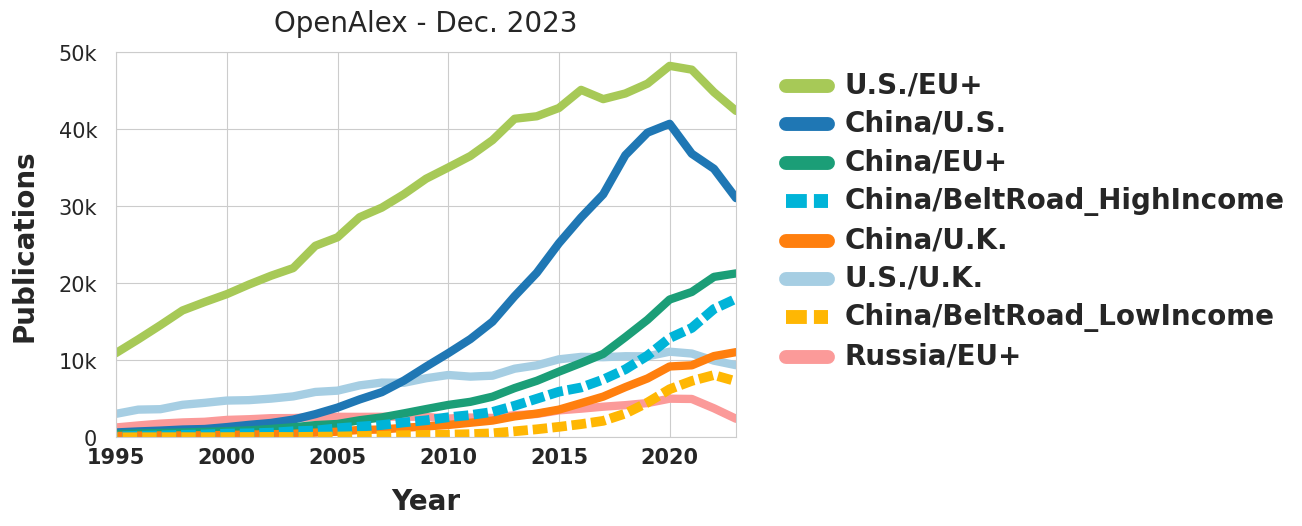

In [8]:
# ---------- Figure 1: 1995–2023 ----------
plot_region_pairs(
    df_all=df_line_main, df_belt=df_line_belt, color_dict=color_dict,
    dash_pairs=belt_pairs, xlim=(1995, 2023), ylim=(0, 50000),     save_file_name="fig_S1"
)

/home/renly/.local/lib/python3.11/site-packages/seaborn/_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/renly/.local/lib/python3.11/site-packages/seaborn/_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/renly/.local/lib/python3.11/site-packages/seaborn/_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/renly/.local/lib/python3.11/site-packages/seaborn/_c

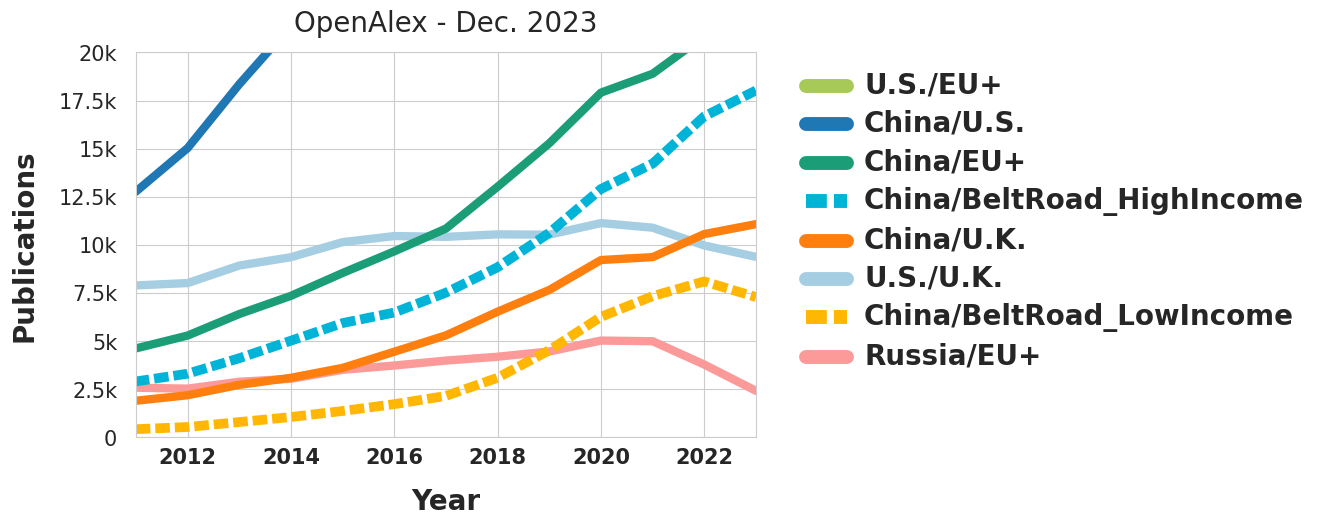

CPU times: user 589 ms, sys: 506 ms, total: 1.1 s
Wall time: 531 ms


In [9]:
%%time
# ---------- Figure 2: 2010–2023 ----------
plot_region_pairs(
    df_all=df_line_main, df_belt=df_line_belt, color_dict=color_dict,
    dash_pairs=belt_pairs, xlim=(2011, 2023), ylim=(0, 20000), save_file_name="fig_S1_extra"
)